In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import data_utils
import train_utils
import models

%reload_ext autoreload
%autoreload 2

torch.manual_seed(8989)

In [22]:
dev = data_utils.COAD_dataset(data_utils.COAD_DEV)
dev_loader = torch.utils.data.DataLoader(dev, batch_size=1, shuffle=True, pin_memory=True)
train = data_utils.COAD_dataset(data_utils.COAD_TRAIN)
train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True, pin_memory=True)
valid = data_utils.COAD_dataset(data_utils.COAD_VALID)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=1, shuffle=False, pin_memory=True)

In [35]:
total_val_tiles = 0

for slide,label in valid_loader:
    total_val_tiles += slide.shape[1]
    
print(total_val_tiles)

10218


In [36]:
n_conv_layers = 2
kernel_size = [4,3]
n_conv_filters = [36,48]
hidden_size = 512
n_rnn_layers = 2
dropout = 0.25
gen = models.Generator(n_conv_layers, kernel_size, n_conv_filters, hidden_size, n_rnn_layers, dropout=dropout)
gen.cuda()

n_conv_layers = 2
n_fc_layers = 2
kernel_size = [4,3]
n_conv_filters = [36,48]
hidden_size = [512,512]
dropout = 0.25
enc = models.ConvNet(n_conv_layers, n_fc_layers, kernel_size, n_conv_filters, hidden_size, dropout=dropout)
enc.cuda()

lamb1 = 1e-7
lamb2 = 0
xent = nn.CrossEntropyLoss()
learning_rate = 1e-4
temp = 3
params = list(enc.parameters()) + list(gen.parameters())
optimizer = torch.optim.Adam(params, lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-6)

In [37]:
weight_tie = True

if weight_tie == True:
    for layer in range(n_conv_layers):
        gen.conv[layer*3].weight.data = enc.conv[layer*3].weight.data

In [38]:
def pool_fn(x):
    #v,a = torch.max(x,0)
    v = torch.mean(x,0)
    return v

In [39]:
best_val_loss = 1e8 
best_val_frac = 0.10

In [40]:
for e in range(500):
    train_utils.rationales_training_loop_GS(e, train_loader, gen, enc, pool_fn, lamb1, lamb2, xent, learning_rate, optimizer,temp)
    loss, frac_tiles, total_tiles = train_utils.rationales_validation_loop_GS(e, valid_loader, gen, enc, pool_fn, xent, scheduler)
    if e > 50:
        lamb1 += 0.01
        temp -= 0.1
    temp = np.max([temp,1.0])
    lamb1 = np.min([lamb1,1.0])
    if e % 5 == 0:
        print('========== Train Set ==========')
        _, _, _ = train_utils.rationales_validation_loop_GS(e, train_loader, gen, enc, pool_fn, xent, scheduler)
        print('Lambda: {0:0.7f}, LR: {1:0.7f}, Temperature: {2:0.7f}'.format(lamb1, optimizer.state_dict()['param_groups'][0]['lr'], temp))
    if loss < best_val_loss and frac_tiles < best_val_frac and total_tiles == total_val_tiles:
        best_val_loss = loss
        torch.save(gen.state_dict(),'generator_weight_tying.pt')
        torch.save(enc.state_dict(),'encoder_weight_tying.pt')
        print('WROTE MODEL!')
    #if frac_tiles < 0.9:
    #    break

Epoch: 0, Train Loss: 34.608220, Train Omega: 0.0000, Fraction of Tiles: 0.4452


/opt/anaconda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 0, Val Loss: 0.0000, Val Acc: nan, Fraction of Tiles: 0.0000, Total Tiles: 0
========== Train Set ==========
Epoch: 0, Val Loss: 0.0000, Val Acc: nan, Fraction of Tiles: 0.0000, Total Tiles: 0
Lambda: 0.0000001, LR: 0.0001000, Temperature: 3.0000000
Epoch: 1, Train Loss: 34.587706, Train Omega: 0.0000, Fraction of Tiles: 0.4841
Epoch: 1, Val Loss: 0.0000, Val Acc: nan, Fraction of Tiles: 0.0000, Total Tiles: 0
Epoch: 2, Train Loss: 34.395633, Train Omega: 0.0000, Fraction of Tiles: 0.4888
Epoch: 2, Val Loss: 0.0000, Val Acc: nan, Fraction of Tiles: 0.0000, Total Tiles: 0
Epoch: 3, Train Loss: 34.364257, Train Omega: 0.0000, Fraction of Tiles: 0.4862
Epoch: 3, Val Loss: 0.0000, Val Acc: nan, Fraction of Tiles: 0.0000, Total Tiles: 0
Epoch: 4, Train Loss: 34.394765, Train Omega: 0.0000, Fraction of Tiles: 0.4888
Epoch: 4, Val Loss: 0.0000, Val Acc: nan, Fraction of Tiles: 0.0000, Total Tiles: 0
Epoch: 5, Train Loss: 34.383977, Train Omega: 0.0000, Fraction of Tiles: 0.4906
Epoch: 

Epoch: 40, Train Loss: 25.673962, Train Omega: 0.0000, Fraction of Tiles: 0.9750
Epoch: 40, Val Loss: 22.4883, Val Acc: 0.8367, Fraction of Tiles: 0.9856, Total Tiles: 10218.0
========== Train Set ==========
Epoch: 40, Val Loss: 27.8575, Val Acc: 0.7200, Fraction of Tiles: 0.9852, Total Tiles: 10144.0
Lambda: 0.0000001, LR: 0.0001000, Temperature: 3.0000000
Epoch: 41, Train Loss: 25.416068, Train Omega: 0.0000, Fraction of Tiles: 0.9794
Epoch: 41, Val Loss: 23.9396, Val Acc: 0.7551, Fraction of Tiles: 0.9904, Total Tiles: 10218.0
Epoch: 42, Train Loss: 25.156785, Train Omega: 0.0000, Fraction of Tiles: 0.9863
Epoch: 42, Val Loss: 26.5321, Val Acc: 0.6531, Fraction of Tiles: 0.9863, Total Tiles: 10218.0
Epoch: 43, Train Loss: 26.577601, Train Omega: 0.0000, Fraction of Tiles: 0.9632
Epoch: 43, Val Loss: 26.2946, Val Acc: 0.8163, Fraction of Tiles: 0.9701, Total Tiles: 10218.0
Epoch: 44, Train Loss: 25.212209, Train Omega: 0.0000, Fraction of Tiles: 0.9573
Epoch: 44, Val Loss: 26.9549, V

KeyboardInterrupt: 

In [40]:
state_dict = torch.load('generator_weight_tying.pt')
gen.load_state_dict(state_dict)
state_dict = torch.load('encoder_weight_tying.pt')
enc.load_state_dict(state_dict)

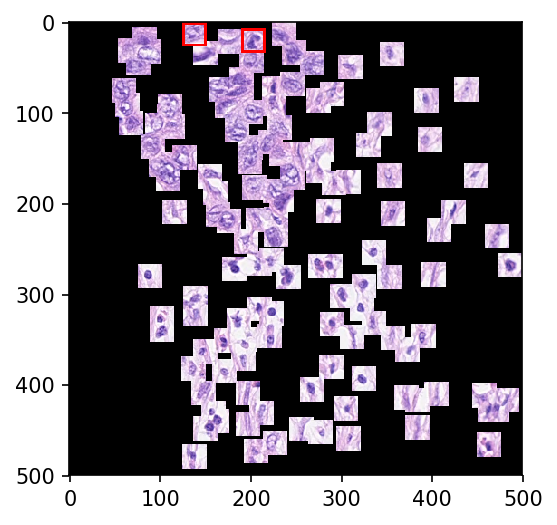

In [187]:
data_utils.draw_image_with_rationale(2,valid,gen)

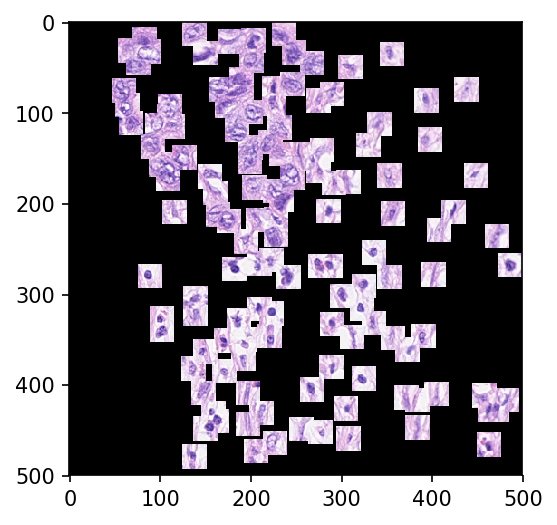

In [159]:
data_utils.make_image_from_slide(valid,idx)

In [91]:
cells_picked_positive = []
cells_picked_negative = []
for idx,slide in enumerate(valid.data):
    slide = slide.cuda().squeeze().view(-1,3,27,27)
    rationale = gen(slide)
    keep = torch.argmax(rationale,2)
    if valid.labels[idx]==1:
        cells_picked_positive.extend(np.array(valid.cell_labels[idx])[keep.squeeze().cpu().numpy()==1])
    else:
        cells_picked_negative.extend(np.array(valid.cell_labels[idx])[keep.squeeze().cpu().numpy()==1])

In [93]:
Counter(cells_picked_positive)

Counter({'epi': 58})

In [94]:
Counter(cells_picked_negative)

Counter({'fibro': 38, 'inf': 2})

In [191]:
labels, preds = train_utils.rationales_evaluation_loop_GS(e, valid_loader, gen, enc, pool_fn, xent, scheduler)

Epoch: 78, Val Loss: 8.8966, Val Acc: 0.9796, Fraction of Tiles: 0.0096, Total Tiles: 10218.0
